### a. Build a Convolutional Neural Network, like what we built in lectures (without skip connections), to classify the images across all 10 classes in CIFAR 10. You need to adjust the fully connected layer at the end properly with respect to the number of output classes. Train your network for 300 epochs. Report your training time, training loss, and evaluation accuracy after 300 epochs. Analyze your results in your report and compare them against a fully connected network (homework 2) on training time, achieved accuracy, and model size.

#### CIFAR 10 setup:

In [53]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device('cuda:0')
print(torch.cuda.is_available())

True


In [54]:
# number of subprocesses to use for data loading
num_workers = 0

# how many samples per batch to load
batch_size = 20

# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

Files already downloaded and verified
Files already downloaded and verified


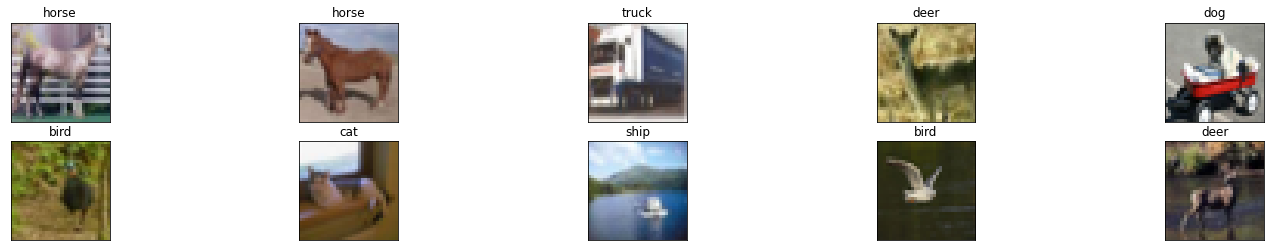

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))

# display 20 images
for idx in np.arange(10):
  ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

#### Model 1 Architecture:

In [56]:
import torch.nn as nn
import torch.nn.functional as F
# define the CNN architecture

class Net1(nn.Module):
  def __init__(self):
    super(Net1, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
  
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

# create a complete CNN
model1 = Net1()
if torch.cuda.is_available():
    model1.cuda()
print(model1)


Net1(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [57]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model1.parameters(), lr=.01)

#### Model 1: training & testing

In [58]:
from tqdm import tqdm

# number of epochs to train the model
n_epochs = 300

#List to store loss to visualize
train_losslist = []

# track change in validation loss
valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):
  print('\nEpoch: {}'.format(epoch))
  # keep track of training and validation loss
  train_loss = 0.0
  valid_loss = 0.0

  print('training: ')  
  with tqdm(train_loader, unit="batch") as tepoch:  
    # train the model
    model1.train()
    for data, target in tepoch:

        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model1(data)
        
        # calculate the batch loss
        loss = criterion(output, target)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update training loss
        train_loss += loss.item()*data.size(0)
        
  print('validation: ')      
  with tqdm(valid_loader, unit="batch") as vepoch:
    # validate the model
    model1.eval()
    for data, target in vepoch:

        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model1(data)
        
        # calculate the batch loss
        loss = criterion(output, target)
        
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
  # calculate average losses
  train_loss = train_loss/len(train_loader.dataset)
  valid_loss = valid_loss/len(valid_loader.dataset)
  train_losslist.append(train_loss)
        
  # print training/validation statistics 
  print('Training Loss: {:.6f} \tValidation Loss: {:.6f}'.format(train_loss, valid_loss))
  
  # save model if validation loss has decreased
  if valid_loss <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_loss_min,
      valid_loss))
      torch.save(model1.state_dict(), 'model1_cifar.pt')
      valid_loss_min = valid_loss

# plt.plot(n_epochs, train_losslist)
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Performance of Model 1")
# plt.show()


Epoch: 1
training: 


100%|██████████| 2000/2000 [00:10<00:00, 185.38batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 234.91batch/s]


Training Loss: 1.742153 	Validation Loss: 0.397787
Validation loss decreased (inf --> 0.397787).  Saving model ...

Epoch: 2
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.85batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 235.32batch/s]


Training Loss: 1.415697 	Validation Loss: 0.316931
Validation loss decreased (0.397787 --> 0.316931).  Saving model ...

Epoch: 3
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.38batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 233.44batch/s]


Training Loss: 1.222207 	Validation Loss: 0.294231
Validation loss decreased (0.316931 --> 0.294231).  Saving model ...

Epoch: 4
training: 


100%|██████████| 2000/2000 [00:10<00:00, 189.11batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 234.80batch/s]


Training Loss: 1.139365 	Validation Loss: 0.277340
Validation loss decreased (0.294231 --> 0.277340).  Saving model ...

Epoch: 5
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.62batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 228.05batch/s]


Training Loss: 1.077094 	Validation Loss: 0.278939

Epoch: 6
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.73batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.11batch/s]


Training Loss: 1.024154 	Validation Loss: 0.256171
Validation loss decreased (0.277340 --> 0.256171).  Saving model ...

Epoch: 7
training: 


100%|██████████| 2000/2000 [00:10<00:00, 187.50batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 236.84batch/s]


Training Loss: 0.979131 	Validation Loss: 0.256784

Epoch: 8
training: 


100%|██████████| 2000/2000 [00:10<00:00, 187.57batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 239.10batch/s]


Training Loss: 0.938866 	Validation Loss: 0.246541
Validation loss decreased (0.256171 --> 0.246541).  Saving model ...

Epoch: 9
training: 


100%|██████████| 2000/2000 [00:10<00:00, 185.92batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.57batch/s]


Training Loss: 0.904215 	Validation Loss: 0.241358
Validation loss decreased (0.246541 --> 0.241358).  Saving model ...

Epoch: 10
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.89batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 239.62batch/s]


Training Loss: 0.871413 	Validation Loss: 0.239089
Validation loss decreased (0.241358 --> 0.239089).  Saving model ...

Epoch: 11
training: 


100%|██████████| 2000/2000 [00:10<00:00, 185.05batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.09batch/s]


Training Loss: 0.842493 	Validation Loss: 0.232463
Validation loss decreased (0.239089 --> 0.232463).  Saving model ...

Epoch: 12
training: 


100%|██████████| 2000/2000 [00:10<00:00, 188.23batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 239.02batch/s]


Training Loss: 0.813996 	Validation Loss: 0.234697

Epoch: 13
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.69batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 236.57batch/s]


Training Loss: 0.790338 	Validation Loss: 0.231895
Validation loss decreased (0.232463 --> 0.231895).  Saving model ...

Epoch: 14
training: 


100%|██████████| 2000/2000 [00:10<00:00, 187.50batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 238.80batch/s]


Training Loss: 0.766410 	Validation Loss: 0.230604
Validation loss decreased (0.231895 --> 0.230604).  Saving model ...

Epoch: 15
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.29batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.11batch/s]


Training Loss: 0.741998 	Validation Loss: 0.229217
Validation loss decreased (0.230604 --> 0.229217).  Saving model ...

Epoch: 16
training: 


100%|██████████| 2000/2000 [00:10<00:00, 185.60batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.17batch/s]


Training Loss: 0.720667 	Validation Loss: 0.241151

Epoch: 17
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.34batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.38batch/s]


Training Loss: 0.699737 	Validation Loss: 0.223267
Validation loss decreased (0.229217 --> 0.223267).  Saving model ...

Epoch: 18
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.82batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.78batch/s]


Training Loss: 0.676997 	Validation Loss: 0.227700

Epoch: 19
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.31batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 233.79batch/s]


Training Loss: 0.656847 	Validation Loss: 0.236881

Epoch: 20
training: 


100%|██████████| 2000/2000 [00:10<00:00, 185.08batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 229.86batch/s]


Training Loss: 0.636161 	Validation Loss: 0.232840

Epoch: 21
training: 


100%|██████████| 2000/2000 [00:10<00:00, 181.88batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.41batch/s]


Training Loss: 0.617245 	Validation Loss: 0.238928

Epoch: 22
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.81batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.58batch/s]


Training Loss: 0.599368 	Validation Loss: 0.233713

Epoch: 23
training: 


100%|██████████| 2000/2000 [00:10<00:00, 185.26batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.47batch/s]


Training Loss: 0.579641 	Validation Loss: 0.238444

Epoch: 24
training: 


100%|██████████| 2000/2000 [00:10<00:00, 186.03batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 207.64batch/s]


Training Loss: 0.564842 	Validation Loss: 0.240822

Epoch: 25
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.27batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.15batch/s]


Training Loss: 0.546592 	Validation Loss: 0.249395

Epoch: 26
training: 


100%|██████████| 2000/2000 [00:10<00:00, 185.34batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.08batch/s]


Training Loss: 0.527043 	Validation Loss: 0.261800

Epoch: 27
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.27batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 234.09batch/s]


Training Loss: 0.510823 	Validation Loss: 0.255527

Epoch: 28
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.65batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.09batch/s]


Training Loss: 0.495074 	Validation Loss: 0.259491

Epoch: 29
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.47batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.65batch/s]


Training Loss: 0.477480 	Validation Loss: 0.274020

Epoch: 30
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.77batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.32batch/s]


Training Loss: 0.461227 	Validation Loss: 0.270511

Epoch: 31
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.34batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 237.11batch/s]


Training Loss: 0.447904 	Validation Loss: 0.273141

Epoch: 32
training: 


100%|██████████| 2000/2000 [00:10<00:00, 185.17batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 235.11batch/s]


Training Loss: 0.433816 	Validation Loss: 0.280902

Epoch: 33
training: 


100%|██████████| 2000/2000 [00:10<00:00, 185.23batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 234.96batch/s]


Training Loss: 0.419734 	Validation Loss: 0.287915

Epoch: 34
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.43batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.33batch/s]


Training Loss: 0.406387 	Validation Loss: 0.301426

Epoch: 35
training: 


100%|██████████| 2000/2000 [00:10<00:00, 186.15batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.98batch/s]


Training Loss: 0.389557 	Validation Loss: 0.295692

Epoch: 36
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.33batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.93batch/s]


Training Loss: 0.375384 	Validation Loss: 0.305126

Epoch: 37
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.70batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.25batch/s]


Training Loss: 0.366201 	Validation Loss: 0.305771

Epoch: 38
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.79batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.74batch/s]


Training Loss: 0.359513 	Validation Loss: 0.322047

Epoch: 39
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.82batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.78batch/s]


Training Loss: 0.343696 	Validation Loss: 0.335388

Epoch: 40
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.71batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.65batch/s]


Training Loss: 0.331573 	Validation Loss: 0.363512

Epoch: 41
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.93batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.13batch/s]


Training Loss: 0.323445 	Validation Loss: 0.355569

Epoch: 42
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.13batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 236.14batch/s]


Training Loss: 0.314438 	Validation Loss: 0.366738

Epoch: 43
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.46batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 235.63batch/s]


Training Loss: 0.303519 	Validation Loss: 0.371927

Epoch: 44
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.61batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 234.53batch/s]


Training Loss: 0.296769 	Validation Loss: 0.368085

Epoch: 45
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.69batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.09batch/s]


Training Loss: 0.287065 	Validation Loss: 0.387733

Epoch: 46
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.91batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.41batch/s]


Training Loss: 0.274866 	Validation Loss: 0.396675

Epoch: 47
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.00batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.54batch/s]


Training Loss: 0.269368 	Validation Loss: 0.406054

Epoch: 48
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.53batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 229.92batch/s]


Training Loss: 0.264711 	Validation Loss: 0.409161

Epoch: 49
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.06batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.84batch/s]


Training Loss: 0.249782 	Validation Loss: 0.412937

Epoch: 50
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.02batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 235.18batch/s]


Training Loss: 0.254642 	Validation Loss: 0.436019

Epoch: 51
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.91batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 236.12batch/s]


Training Loss: 0.239698 	Validation Loss: 0.439904

Epoch: 52
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.31batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 229.73batch/s]


Training Loss: 0.233699 	Validation Loss: 0.450785

Epoch: 53
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.99batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 233.59batch/s]


Training Loss: 0.228878 	Validation Loss: 0.481276

Epoch: 54
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.45batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.51batch/s]


Training Loss: 0.227378 	Validation Loss: 0.483994

Epoch: 55
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.57batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.38batch/s]


Training Loss: 0.224089 	Validation Loss: 0.508387

Epoch: 56
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.27batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 234.22batch/s]


Training Loss: 0.217843 	Validation Loss: 0.507067

Epoch: 57
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.28batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 233.37batch/s]


Training Loss: 0.198839 	Validation Loss: 0.509883

Epoch: 58
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.81batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.97batch/s]


Training Loss: 0.202928 	Validation Loss: 0.510449

Epoch: 59
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.95batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 233.97batch/s]


Training Loss: 0.206365 	Validation Loss: 0.531163

Epoch: 60
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.59batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.71batch/s]


Training Loss: 0.201466 	Validation Loss: 0.517011

Epoch: 61
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.11batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.71batch/s]


Training Loss: 0.200813 	Validation Loss: 0.555995

Epoch: 62
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.61batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 228.12batch/s]


Training Loss: 0.201409 	Validation Loss: 0.537876

Epoch: 63
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.82batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.31batch/s]


Training Loss: 0.192758 	Validation Loss: 0.548054

Epoch: 64
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.05batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 228.51batch/s]


Training Loss: 0.192942 	Validation Loss: 0.570937

Epoch: 65
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.26batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.45batch/s]


Training Loss: 0.179572 	Validation Loss: 0.563241

Epoch: 66
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.87batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.19batch/s]


Training Loss: 0.170014 	Validation Loss: 0.561226

Epoch: 67
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.88batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 234.92batch/s]


Training Loss: 0.169550 	Validation Loss: 0.596416

Epoch: 68
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.25batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.56batch/s]


Training Loss: 0.177846 	Validation Loss: 0.629182

Epoch: 69
training: 


100%|██████████| 2000/2000 [00:10<00:00, 186.24batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 233.04batch/s]


Training Loss: 0.170641 	Validation Loss: 0.600395

Epoch: 70
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.50batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.30batch/s]


Training Loss: 0.158906 	Validation Loss: 0.622969

Epoch: 71
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.32batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.99batch/s]


Training Loss: 0.164415 	Validation Loss: 0.650871

Epoch: 72
training: 


100%|██████████| 2000/2000 [00:11<00:00, 177.07batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.01batch/s]


Training Loss: 0.157421 	Validation Loss: 0.650164

Epoch: 73
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.47batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.17batch/s]


Training Loss: 0.152289 	Validation Loss: 0.636242

Epoch: 74
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.76batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 234.29batch/s]


Training Loss: 0.161401 	Validation Loss: 0.644402

Epoch: 75
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.13batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.96batch/s]


Training Loss: 0.156058 	Validation Loss: 0.666529

Epoch: 76
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.45batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.68batch/s]


Training Loss: 0.149345 	Validation Loss: 0.653627

Epoch: 77
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.57batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.26batch/s]


Training Loss: 0.145460 	Validation Loss: 0.683780

Epoch: 78
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.83batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.32batch/s]


Training Loss: 0.155176 	Validation Loss: 0.685867

Epoch: 79
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.95batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.56batch/s]


Training Loss: 0.143305 	Validation Loss: 0.720439

Epoch: 80
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.66batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 228.26batch/s]


Training Loss: 0.142536 	Validation Loss: 0.706323

Epoch: 81
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.27batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.74batch/s]


Training Loss: 0.148177 	Validation Loss: 0.701392

Epoch: 82
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.60batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.82batch/s]


Training Loss: 0.151340 	Validation Loss: 0.691582

Epoch: 83
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.29batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.74batch/s]


Training Loss: 0.139887 	Validation Loss: 0.738386

Epoch: 84
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.09batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.09batch/s]


Training Loss: 0.142271 	Validation Loss: 0.704026

Epoch: 85
training: 


100%|██████████| 2000/2000 [00:10<00:00, 185.28batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.32batch/s]


Training Loss: 0.140905 	Validation Loss: 0.739692

Epoch: 86
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.66batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.59batch/s]


Training Loss: 0.141194 	Validation Loss: 0.719683

Epoch: 87
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.61batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.62batch/s]


Training Loss: 0.138051 	Validation Loss: 0.762324

Epoch: 88
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.12batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.88batch/s]


Training Loss: 0.138700 	Validation Loss: 0.759981

Epoch: 89
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.66batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.34batch/s]


Training Loss: 0.134356 	Validation Loss: 0.772322

Epoch: 90
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.76batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.50batch/s]


Training Loss: 0.121367 	Validation Loss: 0.767096

Epoch: 91
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.54batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 229.56batch/s]


Training Loss: 0.133057 	Validation Loss: 0.760930

Epoch: 92
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.31batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.33batch/s]


Training Loss: 0.128747 	Validation Loss: 0.759809

Epoch: 93
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.13batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.56batch/s]


Training Loss: 0.120504 	Validation Loss: 0.799568

Epoch: 94
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.16batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.48batch/s]


Training Loss: 0.125975 	Validation Loss: 0.793516

Epoch: 95
training: 


100%|██████████| 2000/2000 [00:10<00:00, 181.98batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 228.23batch/s]


Training Loss: 0.111876 	Validation Loss: 0.842367

Epoch: 96
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.04batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 234.81batch/s]


Training Loss: 0.122737 	Validation Loss: 0.810678

Epoch: 97
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.30batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.33batch/s]


Training Loss: 0.136485 	Validation Loss: 0.794786

Epoch: 98
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.47batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.61batch/s]


Training Loss: 0.128981 	Validation Loss: 0.800777

Epoch: 99
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.25batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.59batch/s]


Training Loss: 0.127920 	Validation Loss: 0.811683

Epoch: 100
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.85batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.90batch/s]


Training Loss: 0.130430 	Validation Loss: 0.806096

Epoch: 101
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.37batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.99batch/s]


Training Loss: 0.128675 	Validation Loss: 0.823051

Epoch: 102
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.79batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.33batch/s]


Training Loss: 0.135418 	Validation Loss: 0.817806

Epoch: 103
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.51batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.23batch/s]


Training Loss: 0.096624 	Validation Loss: 0.833783

Epoch: 104
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.99batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.62batch/s]


Training Loss: 0.091901 	Validation Loss: 0.855552

Epoch: 105
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.68batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 233.91batch/s]


Training Loss: 0.109303 	Validation Loss: 0.868226

Epoch: 106
training: 


100%|██████████| 2000/2000 [00:10<00:00, 186.25batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.69batch/s]


Training Loss: 0.113780 	Validation Loss: 0.847851

Epoch: 107
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.16batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.42batch/s]


Training Loss: 0.118965 	Validation Loss: 0.887375

Epoch: 108
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.98batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.99batch/s]


Training Loss: 0.133915 	Validation Loss: 0.823948

Epoch: 109
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.66batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.40batch/s]


Training Loss: 0.115893 	Validation Loss: 0.862659

Epoch: 110
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.06batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.00batch/s]


Training Loss: 0.093634 	Validation Loss: 0.894685

Epoch: 111
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.25batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 235.64batch/s]


Training Loss: 0.096980 	Validation Loss: 0.923875

Epoch: 112
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.72batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 235.84batch/s]


Training Loss: 0.127961 	Validation Loss: 0.904608

Epoch: 113
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.95batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 229.31batch/s]


Training Loss: 0.139992 	Validation Loss: 0.887664

Epoch: 114
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.92batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.84batch/s]


Training Loss: 0.126678 	Validation Loss: 0.869064

Epoch: 115
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.51batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.91batch/s]


Training Loss: 0.104426 	Validation Loss: 0.939004

Epoch: 116
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.97batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 234.28batch/s]


Training Loss: 0.119709 	Validation Loss: 0.865861

Epoch: 117
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.77batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.51batch/s]


Training Loss: 0.088977 	Validation Loss: 0.928327

Epoch: 118
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.46batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.73batch/s]


Training Loss: 0.125424 	Validation Loss: 0.882526

Epoch: 119
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.74batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.11batch/s]


Training Loss: 0.101771 	Validation Loss: 0.917222

Epoch: 120
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.67batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.58batch/s]


Training Loss: 0.103384 	Validation Loss: 0.920080

Epoch: 121
training: 


100%|██████████| 2000/2000 [00:10<00:00, 185.11batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 229.89batch/s]


Training Loss: 0.100992 	Validation Loss: 0.935277

Epoch: 122
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.56batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.26batch/s]


Training Loss: 0.108062 	Validation Loss: 0.959628

Epoch: 123
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.31batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.75batch/s]


Training Loss: 0.110759 	Validation Loss: 0.952844

Epoch: 124
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.31batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.54batch/s]


Training Loss: 0.098391 	Validation Loss: 0.999206

Epoch: 125
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.00batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.12batch/s]


Training Loss: 0.116742 	Validation Loss: 0.980595

Epoch: 126
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.23batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 236.49batch/s]


Training Loss: 0.133573 	Validation Loss: 0.924838

Epoch: 127
training: 


100%|██████████| 2000/2000 [00:10<00:00, 181.82batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 229.47batch/s]


Training Loss: 0.112048 	Validation Loss: 0.970753

Epoch: 128
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.03batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.15batch/s]


Training Loss: 0.114005 	Validation Loss: 0.963223

Epoch: 129
training: 


100%|██████████| 2000/2000 [00:11<00:00, 176.21batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.43batch/s]


Training Loss: 0.105422 	Validation Loss: 0.974229

Epoch: 130
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.61batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.91batch/s]


Training Loss: 0.097553 	Validation Loss: 0.971371

Epoch: 131
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.36batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.67batch/s]


Training Loss: 0.099204 	Validation Loss: 1.013128

Epoch: 132
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.14batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 229.05batch/s]


Training Loss: 0.104800 	Validation Loss: 0.991495

Epoch: 133
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.76batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.62batch/s]


Training Loss: 0.112187 	Validation Loss: 0.990775

Epoch: 134
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.67batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 234.07batch/s]


Training Loss: 0.088256 	Validation Loss: 1.014300

Epoch: 135
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.32batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.57batch/s]


Training Loss: 0.107183 	Validation Loss: 0.987338

Epoch: 136
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.13batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 233.24batch/s]


Training Loss: 0.099687 	Validation Loss: 1.058698

Epoch: 137
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.75batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 228.83batch/s]


Training Loss: 0.116935 	Validation Loss: 0.999684

Epoch: 138
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.74batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.74batch/s]


Training Loss: 0.114145 	Validation Loss: 0.992787

Epoch: 139
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.86batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.91batch/s]


Training Loss: 0.085783 	Validation Loss: 1.058782

Epoch: 140
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.94batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.13batch/s]


Training Loss: 0.104536 	Validation Loss: 1.056315

Epoch: 141
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.19batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.58batch/s]


Training Loss: 0.085763 	Validation Loss: 1.042270

Epoch: 142
training: 


100%|██████████| 2000/2000 [00:10<00:00, 185.50batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.30batch/s]


Training Loss: 0.100077 	Validation Loss: 1.051808

Epoch: 143
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.02batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.22batch/s]


Training Loss: 0.117933 	Validation Loss: 1.058656

Epoch: 144
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.54batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.83batch/s]


Training Loss: 0.116548 	Validation Loss: 1.031979

Epoch: 145
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.44batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.79batch/s]


Training Loss: 0.108022 	Validation Loss: 1.063053

Epoch: 146
training: 


100%|██████████| 2000/2000 [00:10<00:00, 181.92batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 228.80batch/s]


Training Loss: 0.089635 	Validation Loss: 1.055623

Epoch: 147
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.30batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.60batch/s]


Training Loss: 0.097243 	Validation Loss: 1.048896

Epoch: 148
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.65batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.60batch/s]


Training Loss: 0.099278 	Validation Loss: 1.051614

Epoch: 149
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.60batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.51batch/s]


Training Loss: 0.114157 	Validation Loss: 1.090956

Epoch: 150
training: 


100%|██████████| 2000/2000 [00:11<00:00, 175.84batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.87batch/s]


Training Loss: 0.131001 	Validation Loss: 1.048760

Epoch: 151
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.44batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 228.61batch/s]


Training Loss: 0.101758 	Validation Loss: 1.057365

Epoch: 152
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.48batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 228.55batch/s]


Training Loss: 0.101877 	Validation Loss: 1.127379

Epoch: 153
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.95batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.30batch/s]


Training Loss: 0.140533 	Validation Loss: 1.054916

Epoch: 154
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.87batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.21batch/s]


Training Loss: 0.124994 	Validation Loss: 1.041801

Epoch: 155
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.25batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.46batch/s]


Training Loss: 0.108497 	Validation Loss: 1.051421

Epoch: 156
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.68batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.18batch/s]


Training Loss: 0.091843 	Validation Loss: 1.114421

Epoch: 157
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.37batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.25batch/s]


Training Loss: 0.078921 	Validation Loss: 1.057639

Epoch: 158
training: 


100%|██████████| 2000/2000 [00:11<00:00, 177.46batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.01batch/s]


Training Loss: 0.081547 	Validation Loss: 1.080447

Epoch: 159
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.78batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.24batch/s]


Training Loss: 0.088578 	Validation Loss: 1.118861

Epoch: 160
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.91batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.46batch/s]


Training Loss: 0.097200 	Validation Loss: 1.115822

Epoch: 161
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.87batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.39batch/s]


Training Loss: 0.129749 	Validation Loss: 1.101750

Epoch: 162
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.06batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.82batch/s]


Training Loss: 0.118097 	Validation Loss: 1.100850

Epoch: 163
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.77batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.89batch/s]


Training Loss: 0.091128 	Validation Loss: 1.127924

Epoch: 164
training: 


100%|██████████| 2000/2000 [00:11<00:00, 176.52batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.21batch/s]


Training Loss: 0.093307 	Validation Loss: 1.111400

Epoch: 165
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.92batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 208.88batch/s]


Training Loss: 0.120839 	Validation Loss: 1.098006

Epoch: 166
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.84batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.86batch/s]


Training Loss: 0.102398 	Validation Loss: 1.134418

Epoch: 167
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.33batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.64batch/s]


Training Loss: 0.099558 	Validation Loss: 1.122616

Epoch: 168
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.53batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.18batch/s]


Training Loss: 0.124893 	Validation Loss: 1.113424

Epoch: 169
training: 


100%|██████████| 2000/2000 [00:11<00:00, 176.12batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.44batch/s]


Training Loss: 0.132611 	Validation Loss: 1.134979

Epoch: 170
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.56batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.72batch/s]


Training Loss: 0.105372 	Validation Loss: 1.179605

Epoch: 171
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.03batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.17batch/s]


Training Loss: 0.091190 	Validation Loss: 1.184723

Epoch: 172
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.56batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.45batch/s]


Training Loss: 0.113007 	Validation Loss: 1.182225

Epoch: 173
training: 


100%|██████████| 2000/2000 [00:10<00:00, 181.98batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 229.24batch/s]


Training Loss: 0.101327 	Validation Loss: 1.180392

Epoch: 174
training: 


100%|██████████| 2000/2000 [00:11<00:00, 176.45batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 229.77batch/s]


Training Loss: 0.106028 	Validation Loss: 1.136220

Epoch: 175
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.46batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.51batch/s]


Training Loss: 0.111815 	Validation Loss: 1.136307

Epoch: 176
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.69batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.88batch/s]


Training Loss: 0.098677 	Validation Loss: 1.203016

Epoch: 177
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.83batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.00batch/s]


Training Loss: 0.093524 	Validation Loss: 1.247010

Epoch: 178
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.01batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.36batch/s]


Training Loss: 0.108915 	Validation Loss: 1.165294

Epoch: 179
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.95batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.25batch/s]


Training Loss: 0.113306 	Validation Loss: 1.185365

Epoch: 180
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.62batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.51batch/s]


Training Loss: 0.115618 	Validation Loss: 1.187635

Epoch: 181
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.94batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.13batch/s]


Training Loss: 0.114756 	Validation Loss: 1.215164

Epoch: 182
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.56batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.75batch/s]


Training Loss: 0.123549 	Validation Loss: 1.167151

Epoch: 183
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.53batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.61batch/s]


Training Loss: 0.101473 	Validation Loss: 1.201090

Epoch: 184
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.80batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.07batch/s]


Training Loss: 0.106986 	Validation Loss: 1.173719

Epoch: 185
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.20batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.93batch/s]


Training Loss: 0.112759 	Validation Loss: 1.184816

Epoch: 186
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.32batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.29batch/s]


Training Loss: 0.117902 	Validation Loss: 1.208639

Epoch: 187
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.01batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.75batch/s]


Training Loss: 0.102582 	Validation Loss: 1.209177

Epoch: 188
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.80batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.40batch/s]


Training Loss: 0.073738 	Validation Loss: 1.190094

Epoch: 189
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.69batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.39batch/s]


Training Loss: 0.097971 	Validation Loss: 1.234775

Epoch: 190
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.04batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.19batch/s]


Training Loss: 0.112064 	Validation Loss: 1.257413

Epoch: 191
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.00batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 229.39batch/s]


Training Loss: 0.120855 	Validation Loss: 1.221743

Epoch: 192
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.82batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.19batch/s]


Training Loss: 0.122189 	Validation Loss: 1.199835

Epoch: 193
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.19batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.07batch/s]


Training Loss: 0.081864 	Validation Loss: 1.241649

Epoch: 194
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.80batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.68batch/s]


Training Loss: 0.113748 	Validation Loss: 1.253795

Epoch: 195
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.99batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.45batch/s]


Training Loss: 0.125756 	Validation Loss: 1.240292

Epoch: 196
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.22batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.73batch/s]


Training Loss: 0.111013 	Validation Loss: 1.297486

Epoch: 197
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.76batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 229.77batch/s]


Training Loss: 0.123386 	Validation Loss: 1.213063

Epoch: 198
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.92batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.67batch/s]


Training Loss: 0.097512 	Validation Loss: 1.225649

Epoch: 199
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.92batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.78batch/s]


Training Loss: 0.107378 	Validation Loss: 1.264530

Epoch: 200
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.31batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 234.48batch/s]


Training Loss: 0.107984 	Validation Loss: 1.257036

Epoch: 201
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.27batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.94batch/s]


Training Loss: 0.104862 	Validation Loss: 1.263091

Epoch: 202
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.15batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.01batch/s]


Training Loss: 0.109652 	Validation Loss: 1.218913

Epoch: 203
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.13batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.03batch/s]


Training Loss: 0.127925 	Validation Loss: 1.219432

Epoch: 204
training: 


100%|██████████| 2000/2000 [00:10<00:00, 181.99batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.21batch/s]


Training Loss: 0.101512 	Validation Loss: 1.242182

Epoch: 205
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.45batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.97batch/s]


Training Loss: 0.108632 	Validation Loss: 1.238891

Epoch: 206
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.16batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.98batch/s]


Training Loss: 0.128981 	Validation Loss: 1.240658

Epoch: 207
training: 


100%|██████████| 2000/2000 [00:11<00:00, 177.84batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.59batch/s]


Training Loss: 0.121921 	Validation Loss: 1.236565

Epoch: 208
training: 


100%|██████████| 2000/2000 [00:10<00:00, 181.95batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.70batch/s]


Training Loss: 0.105190 	Validation Loss: 1.280836

Epoch: 209
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.81batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.67batch/s]


Training Loss: 0.097144 	Validation Loss: 1.310141

Epoch: 210
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.33batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.84batch/s]


Training Loss: 0.108875 	Validation Loss: 1.282397

Epoch: 211
training: 


100%|██████████| 2000/2000 [00:11<00:00, 176.44batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 234.95batch/s]


Training Loss: 0.145724 	Validation Loss: 1.239434

Epoch: 212
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.48batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.83batch/s]


Training Loss: 0.099776 	Validation Loss: 1.302056

Epoch: 213
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.61batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.66batch/s]


Training Loss: 0.125328 	Validation Loss: 1.277213

Epoch: 214
training: 


100%|██████████| 2000/2000 [00:10<00:00, 181.95batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 229.70batch/s]


Training Loss: 0.111098 	Validation Loss: 1.255532

Epoch: 215
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.39batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.06batch/s]


Training Loss: 0.110572 	Validation Loss: 1.268670

Epoch: 216
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.91batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.41batch/s]


Training Loss: 0.082616 	Validation Loss: 1.318466

Epoch: 217
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.10batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.33batch/s]


Training Loss: 0.109593 	Validation Loss: 1.354217

Epoch: 218
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.72batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 229.60batch/s]


Training Loss: 0.135968 	Validation Loss: 1.260713

Epoch: 219
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.44batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.99batch/s]


Training Loss: 0.117996 	Validation Loss: 1.315127

Epoch: 220
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.10batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.18batch/s]


Training Loss: 0.124211 	Validation Loss: 1.260210

Epoch: 221
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.38batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 234.79batch/s]


Training Loss: 0.115016 	Validation Loss: 1.302613

Epoch: 222
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.32batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.34batch/s]


Training Loss: 0.104476 	Validation Loss: 1.294961

Epoch: 223
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.96batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.71batch/s]


Training Loss: 0.104741 	Validation Loss: 1.336375

Epoch: 224
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.81batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.88batch/s]


Training Loss: 0.111030 	Validation Loss: 1.340752

Epoch: 225
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.01batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.04batch/s]


Training Loss: 0.119438 	Validation Loss: 1.304094

Epoch: 226
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.73batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.35batch/s]


Training Loss: 0.130782 	Validation Loss: 1.289222

Epoch: 227
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.53batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.82batch/s]


Training Loss: 0.112611 	Validation Loss: 1.277651

Epoch: 228
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.25batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 233.75batch/s]


Training Loss: 0.105882 	Validation Loss: 1.313225

Epoch: 229
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.20batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.51batch/s]


Training Loss: 0.079505 	Validation Loss: 1.348496

Epoch: 230
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.21batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.41batch/s]


Training Loss: 0.108194 	Validation Loss: 1.364499

Epoch: 231
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.23batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 228.11batch/s]


Training Loss: 0.156093 	Validation Loss: 1.289402

Epoch: 232
training: 


100%|██████████| 2000/2000 [00:11<00:00, 175.92batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.15batch/s]


Training Loss: 0.098820 	Validation Loss: 1.344444

Epoch: 233
training: 


100%|██████████| 2000/2000 [00:11<00:00, 176.17batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.48batch/s]


Training Loss: 0.112531 	Validation Loss: 1.403293

Epoch: 234
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.14batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 228.75batch/s]


Training Loss: 0.099683 	Validation Loss: 1.409825

Epoch: 235
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.62batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.89batch/s]


Training Loss: 0.109004 	Validation Loss: 1.333842

Epoch: 236
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.99batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.49batch/s]


Training Loss: 0.101558 	Validation Loss: 1.333720

Epoch: 237
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.11batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.83batch/s]


Training Loss: 0.116456 	Validation Loss: 1.343711

Epoch: 238
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.58batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 228.53batch/s]


Training Loss: 0.133599 	Validation Loss: 1.361228

Epoch: 239
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.59batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.98batch/s]


Training Loss: 0.141475 	Validation Loss: 1.375798

Epoch: 240
training: 


100%|██████████| 2000/2000 [00:10<00:00, 184.33batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.06batch/s]


Training Loss: 0.147850 	Validation Loss: 1.286572

Epoch: 241
training: 


100%|██████████| 2000/2000 [00:11<00:00, 177.74batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.97batch/s]


Training Loss: 0.106532 	Validation Loss: 1.340145

Epoch: 242
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.29batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 231.11batch/s]


Training Loss: 0.123762 	Validation Loss: 1.396832

Epoch: 243
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.55batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.36batch/s]


Training Loss: 0.132393 	Validation Loss: 1.334991

Epoch: 244
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.41batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.21batch/s]


Training Loss: 0.097960 	Validation Loss: 1.374670

Epoch: 245
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.02batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.87batch/s]


Training Loss: 0.138209 	Validation Loss: 1.346232

Epoch: 246
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.69batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.76batch/s]


Training Loss: 0.118205 	Validation Loss: 1.402921

Epoch: 247
training: 


100%|██████████| 2000/2000 [00:11<00:00, 176.74batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.43batch/s]


Training Loss: 0.105233 	Validation Loss: 1.397035

Epoch: 248
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.87batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.03batch/s]


Training Loss: 0.102202 	Validation Loss: 1.348765

Epoch: 249
training: 


100%|██████████| 2000/2000 [00:11<00:00, 176.64batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.43batch/s]


Training Loss: 0.117211 	Validation Loss: 1.412271

Epoch: 250
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.66batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.23batch/s]


Training Loss: 0.114430 	Validation Loss: 1.375496

Epoch: 251
training: 


100%|██████████| 2000/2000 [00:11<00:00, 177.15batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.57batch/s]


Training Loss: 0.119349 	Validation Loss: 1.397631

Epoch: 252
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.53batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.43batch/s]


Training Loss: 0.131280 	Validation Loss: 1.396507

Epoch: 253
training: 


100%|██████████| 2000/2000 [00:11<00:00, 176.64batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 228.09batch/s]


Training Loss: 0.115739 	Validation Loss: 1.379126

Epoch: 254
training: 


100%|██████████| 2000/2000 [00:11<00:00, 177.69batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.88batch/s]


Training Loss: 0.101896 	Validation Loss: 1.405457

Epoch: 255
training: 


100%|██████████| 2000/2000 [00:11<00:00, 177.22batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.31batch/s]


Training Loss: 0.101088 	Validation Loss: 1.386937

Epoch: 256
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.04batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.59batch/s]


Training Loss: 0.130724 	Validation Loss: 1.356971

Epoch: 257
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.02batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.42batch/s]


Training Loss: 0.142466 	Validation Loss: 1.358394

Epoch: 258
training: 


100%|██████████| 2000/2000 [00:10<00:00, 183.20batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.35batch/s]


Training Loss: 0.090771 	Validation Loss: 1.373173

Epoch: 259
training: 


100%|██████████| 2000/2000 [00:11<00:00, 177.19batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.59batch/s]


Training Loss: 0.088915 	Validation Loss: 1.392543

Epoch: 260
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.29batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.12batch/s]


Training Loss: 0.115927 	Validation Loss: 1.425388

Epoch: 261
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.30batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.44batch/s]


Training Loss: 0.135635 	Validation Loss: 1.412268

Epoch: 262
training: 


100%|██████████| 2000/2000 [00:11<00:00, 176.51batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.83batch/s]


Training Loss: 0.139911 	Validation Loss: 1.427894

Epoch: 263
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.65batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 228.49batch/s]


Training Loss: 0.122771 	Validation Loss: 1.446559

Epoch: 264
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.26batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.50batch/s]


Training Loss: 0.143944 	Validation Loss: 1.404121

Epoch: 265
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.54batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.64batch/s]


Training Loss: 0.168357 	Validation Loss: 1.356233

Epoch: 266
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.59batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 229.73batch/s]


Training Loss: 0.122089 	Validation Loss: 1.406616

Epoch: 267
training: 


100%|██████████| 2000/2000 [00:11<00:00, 177.24batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.17batch/s]


Training Loss: 0.110571 	Validation Loss: 1.375023

Epoch: 268
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.42batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.54batch/s]


Training Loss: 0.096522 	Validation Loss: 1.444915

Epoch: 269
training: 


100%|██████████| 2000/2000 [00:11<00:00, 177.67batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.04batch/s]


Training Loss: 0.109337 	Validation Loss: 1.450371

Epoch: 270
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.61batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.33batch/s]


Training Loss: 0.114031 	Validation Loss: 1.521613

Epoch: 271
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.56batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.75batch/s]


Training Loss: 0.135487 	Validation Loss: 1.479969

Epoch: 272
training: 


100%|██████████| 2000/2000 [00:11<00:00, 177.06batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.13batch/s]


Training Loss: 0.136371 	Validation Loss: 1.490258

Epoch: 273
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.43batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.72batch/s]


Training Loss: 0.159159 	Validation Loss: 1.386118

Epoch: 274
training: 


100%|██████████| 2000/2000 [00:11<00:00, 175.14batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.65batch/s]


Training Loss: 0.114178 	Validation Loss: 1.438920

Epoch: 275
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.48batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.16batch/s]


Training Loss: 0.108245 	Validation Loss: 1.628754

Epoch: 276
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.73batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.56batch/s]


Training Loss: 0.115107 	Validation Loss: 1.444432

Epoch: 277
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.75batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.44batch/s]


Training Loss: 0.113743 	Validation Loss: 1.481494

Epoch: 278
training: 


100%|██████████| 2000/2000 [00:11<00:00, 177.63batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.46batch/s]


Training Loss: 0.140289 	Validation Loss: 1.492847

Epoch: 279
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.30batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.48batch/s]


Training Loss: 0.147623 	Validation Loss: 1.456498

Epoch: 280
training: 


100%|██████████| 2000/2000 [00:11<00:00, 177.20batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.63batch/s]


Training Loss: 0.102613 	Validation Loss: 1.480939

Epoch: 281
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.02batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.39batch/s]


Training Loss: 0.119027 	Validation Loss: 1.472257

Epoch: 282
training: 


100%|██████████| 2000/2000 [00:10<00:00, 182.51batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.04batch/s]


Training Loss: 0.127675 	Validation Loss: 1.436420

Epoch: 283
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.70batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.21batch/s]


Training Loss: 0.107238 	Validation Loss: 1.545008

Epoch: 284
training: 


100%|██████████| 2000/2000 [00:11<00:00, 176.86batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.44batch/s]


Training Loss: 0.167777 	Validation Loss: 1.441768

Epoch: 285
training: 


100%|██████████| 2000/2000 [00:11<00:00, 177.07batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.89batch/s]


Training Loss: 0.163323 	Validation Loss: 1.404873

Epoch: 286
training: 


100%|██████████| 2000/2000 [00:11<00:00, 176.31batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.75batch/s]


Training Loss: 0.094617 	Validation Loss: 1.494383

Epoch: 287
training: 


100%|██████████| 2000/2000 [00:11<00:00, 178.68batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.79batch/s]


Training Loss: 0.087350 	Validation Loss: 1.497414

Epoch: 288
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.43batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.77batch/s]


Training Loss: 0.079304 	Validation Loss: 1.525726

Epoch: 289
training: 


100%|██████████| 2000/2000 [00:11<00:00, 174.56batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 230.74batch/s]


Training Loss: 0.139201 	Validation Loss: 1.506493

Epoch: 290
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.44batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.29batch/s]


Training Loss: 0.174293 	Validation Loss: 1.471359

Epoch: 291
training: 


100%|██████████| 2000/2000 [00:11<00:00, 177.87batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.69batch/s]


Training Loss: 0.150189 	Validation Loss: 1.476064

Epoch: 292
training: 


100%|██████████| 2000/2000 [00:11<00:00, 179.46batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 229.82batch/s]


Training Loss: 0.164765 	Validation Loss: 1.409631

Epoch: 293
training: 


100%|██████████| 2000/2000 [00:11<00:00, 180.37batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.43batch/s]


Training Loss: 0.161118 	Validation Loss: 1.463418

Epoch: 294
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.38batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.44batch/s]


Training Loss: 0.118202 	Validation Loss: 1.459215

Epoch: 295
training: 


100%|██████████| 2000/2000 [00:11<00:00, 175.02batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.22batch/s]


Training Loss: 0.118049 	Validation Loss: 1.436777

Epoch: 296
training: 


100%|██████████| 2000/2000 [00:10<00:00, 181.93batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.79batch/s]


Training Loss: 0.083758 	Validation Loss: 1.505250

Epoch: 297
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.89batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.01batch/s]


Training Loss: 0.088616 	Validation Loss: 1.553454

Epoch: 298
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.20batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 228.75batch/s]


Training Loss: 0.107585 	Validation Loss: 1.527042

Epoch: 299
training: 


100%|██████████| 2000/2000 [00:11<00:00, 176.66batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.72batch/s]


Training Loss: 0.121596 	Validation Loss: 1.575408

Epoch: 300
training: 


100%|██████████| 2000/2000 [00:11<00:00, 181.46batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.83batch/s]

Training Loss: 0.127120 	Validation Loss: 1.574147


In [59]:
model1.load_state_dict(torch.load('model1_cifar.pt'))

<All keys matched successfully>

In [64]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model1.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model1(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.098158

Test Accuracy of airplane: 66% (663/1000)
Test Accuracy of automobile: 75% (756/1000)
Test Accuracy of  bird: 54% (547/1000)
Test Accuracy of   cat: 47% (476/1000)
Test Accuracy of  deer: 49% (497/1000)
Test Accuracy of   dog: 45% (455/1000)
Test Accuracy of  frog: 70% (702/1000)
Test Accuracy of horse: 70% (709/1000)
Test Accuracy of  ship: 80% (809/1000)
Test Accuracy of truck: 61% (616/1000)

Test Accuracy (Overall): 62% (6230/10000)


### b. Extend your CNN by adding one more additional convolution layer followed by an activation function and pooling function. You also need to adjust your fully connected layer properly with respect to intermediate feature dimensions. Train your network for 300 epochs. Report your training time, loss, and evaluation accuracy after 300 epochs. Analyze your results in your report and compare your model size and accuracy over the baseline implementation in Problem1.a. Do you see any over-fitting? Make sure to submit your code by providing the GitHub URL of your course repository for this course.

#### Model 2 Architecture:

In [65]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        # dropout
        self.dropout = nn.Dropout(p=.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flattening
        x = x.view(-1, 64 * 4 * 4)
        # fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

model2 = Net2()
if torch.cuda.is_available():
    model2.cuda()
print(model2)

Net2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [66]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model2.parameters(), lr=.01)

#### Model 2: training & testing

In [67]:
from tqdm import tqdm

# number of epochs to train the model
n_epochs = 300

#List to store loss to visualize
train_losslist = []

# track change in validation loss
valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):
  print('\nEpoch: {}'.format(epoch))
  # keep track of training and validation loss
  train_loss = 0.0
  valid_loss = 0.0

  print('training: ')  
  with tqdm(train_loader, unit="batch") as tepoch:  
    # train the model
    model2.train()
    for data, target in tepoch:

        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model2(data)
        
        # calculate the batch loss
        loss = criterion(output, target)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update training loss
        train_loss += loss.item()*data.size(0)
        
  print('validation: ')      
  with tqdm(valid_loader, unit="batch") as vepoch:
    # validate the model
    model2.eval()
    for data, target in vepoch:

        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model2(data)
        
        # calculate the batch loss
        loss = criterion(output, target)
        
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
  # calculate average losses
  train_loss = train_loss/len(train_loader.dataset)
  valid_loss = valid_loss/len(valid_loader.dataset)
  train_losslist.append(train_loss)
        
  # print training/validation statistics 
  print('Training Loss: {:.6f} \tValidation Loss: {:.6f}'.format(train_loss, valid_loss))
  
  # save model if validation loss has decreased
  if valid_loss <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_loss_min,
      valid_loss))
      torch.save(model2.state_dict(), 'model2_cifar.pt')
      valid_loss_min = valid_loss


Epoch: 1
training: 


100%|██████████| 2000/2000 [00:11<00:00, 172.71batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.03batch/s]


Training Loss: 1.819947 	Validation Loss: 0.423954
Validation loss decreased (inf --> 0.423954).  Saving model ...

Epoch: 2
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.48batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.66batch/s]


Training Loss: 1.571010 	Validation Loss: 0.345569
Validation loss decreased (0.423954 --> 0.345569).  Saving model ...

Epoch: 3
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.52batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.07batch/s]


Training Loss: 1.385076 	Validation Loss: 0.317416
Validation loss decreased (0.345569 --> 0.317416).  Saving model ...

Epoch: 4
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.24batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.33batch/s]


Training Loss: 1.294881 	Validation Loss: 0.298770
Validation loss decreased (0.317416 --> 0.298770).  Saving model ...

Epoch: 5
training: 


100%|██████████| 2000/2000 [00:12<00:00, 164.50batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.52batch/s]


Training Loss: 1.225411 	Validation Loss: 0.280301
Validation loss decreased (0.298770 --> 0.280301).  Saving model ...

Epoch: 6
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.46batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.38batch/s]


Training Loss: 1.149116 	Validation Loss: 0.265464
Validation loss decreased (0.280301 --> 0.265464).  Saving model ...

Epoch: 7
training: 


100%|██████████| 2000/2000 [00:11<00:00, 172.85batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.72batch/s]


Training Loss: 1.081474 	Validation Loss: 0.253437
Validation loss decreased (0.265464 --> 0.253437).  Saving model ...

Epoch: 8
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.21batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.70batch/s]


Training Loss: 1.020743 	Validation Loss: 0.232464
Validation loss decreased (0.253437 --> 0.232464).  Saving model ...

Epoch: 9
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.71batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.75batch/s]


Training Loss: 0.974432 	Validation Loss: 0.229306
Validation loss decreased (0.232464 --> 0.229306).  Saving model ...

Epoch: 10
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.96batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.99batch/s]


Training Loss: 0.925396 	Validation Loss: 0.213944
Validation loss decreased (0.229306 --> 0.213944).  Saving model ...

Epoch: 11
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.69batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.48batch/s]


Training Loss: 0.883758 	Validation Loss: 0.218478

Epoch: 12
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.13batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.60batch/s]


Training Loss: 0.844422 	Validation Loss: 0.203454
Validation loss decreased (0.213944 --> 0.203454).  Saving model ...

Epoch: 13
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.25batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.32batch/s]


Training Loss: 0.807741 	Validation Loss: 0.194698
Validation loss decreased (0.203454 --> 0.194698).  Saving model ...

Epoch: 14
training: 


100%|██████████| 2000/2000 [00:11<00:00, 173.14batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 229.21batch/s]


Training Loss: 0.776220 	Validation Loss: 0.184167
Validation loss decreased (0.194698 --> 0.184167).  Saving model ...

Epoch: 15
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.13batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.34batch/s]


Training Loss: 0.744107 	Validation Loss: 0.179757
Validation loss decreased (0.184167 --> 0.179757).  Saving model ...

Epoch: 16
training: 


100%|██████████| 2000/2000 [00:11<00:00, 173.44batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.45batch/s]


Training Loss: 0.718520 	Validation Loss: 0.176575
Validation loss decreased (0.179757 --> 0.176575).  Saving model ...

Epoch: 17
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.71batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.94batch/s]


Training Loss: 0.686591 	Validation Loss: 0.175371
Validation loss decreased (0.176575 --> 0.175371).  Saving model ...

Epoch: 18
training: 


100%|██████████| 2000/2000 [00:11<00:00, 172.66batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.99batch/s]


Training Loss: 0.661447 	Validation Loss: 0.171909
Validation loss decreased (0.175371 --> 0.171909).  Saving model ...

Epoch: 19
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.69batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.57batch/s]


Training Loss: 0.635237 	Validation Loss: 0.167376
Validation loss decreased (0.171909 --> 0.167376).  Saving model ...

Epoch: 20
training: 


100%|██████████| 2000/2000 [00:11<00:00, 173.38batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 228.75batch/s]


Training Loss: 0.605125 	Validation Loss: 0.166019
Validation loss decreased (0.167376 --> 0.166019).  Saving model ...

Epoch: 21
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.47batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.87batch/s]


Training Loss: 0.588252 	Validation Loss: 0.164528
Validation loss decreased (0.166019 --> 0.164528).  Saving model ...

Epoch: 22
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.54batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.43batch/s]


Training Loss: 0.561954 	Validation Loss: 0.158653
Validation loss decreased (0.164528 --> 0.158653).  Saving model ...

Epoch: 23
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.68batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 229.16batch/s]


Training Loss: 0.539131 	Validation Loss: 0.164091

Epoch: 24
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.97batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.51batch/s]


Training Loss: 0.518570 	Validation Loss: 0.161981

Epoch: 25
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.43batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.29batch/s]


Training Loss: 0.497394 	Validation Loss: 0.166268

Epoch: 26
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.43batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.82batch/s]


Training Loss: 0.478325 	Validation Loss: 0.162026

Epoch: 27
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.10batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.79batch/s]


Training Loss: 0.463475 	Validation Loss: 0.170056

Epoch: 28
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.18batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.22batch/s]


Training Loss: 0.444010 	Validation Loss: 0.162984

Epoch: 29
training: 


100%|██████████| 2000/2000 [00:11<00:00, 172.05batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.51batch/s]


Training Loss: 0.423135 	Validation Loss: 0.164009

Epoch: 30
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.15batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.17batch/s]


Training Loss: 0.405842 	Validation Loss: 0.168724

Epoch: 31
training: 


100%|██████████| 2000/2000 [00:11<00:00, 172.50batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.11batch/s]


Training Loss: 0.396476 	Validation Loss: 0.167410

Epoch: 32
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.68batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.00batch/s]


Training Loss: 0.374158 	Validation Loss: 0.181640

Epoch: 33
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.56batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.04batch/s]


Training Loss: 0.363932 	Validation Loss: 0.180513

Epoch: 34
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.84batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.25batch/s]


Training Loss: 0.348710 	Validation Loss: 0.173950

Epoch: 35
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.74batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.21batch/s]


Training Loss: 0.332004 	Validation Loss: 0.182104

Epoch: 36
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.80batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.96batch/s]


Training Loss: 0.318535 	Validation Loss: 0.176093

Epoch: 37
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.98batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 229.04batch/s]


Training Loss: 0.309697 	Validation Loss: 0.183457

Epoch: 38
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.57batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.54batch/s]


Training Loss: 0.301579 	Validation Loss: 0.188362

Epoch: 39
training: 


100%|██████████| 2000/2000 [00:11<00:00, 173.10batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 228.40batch/s]


Training Loss: 0.288470 	Validation Loss: 0.185974

Epoch: 40
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.60batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.52batch/s]


Training Loss: 0.284995 	Validation Loss: 0.180585

Epoch: 41
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.67batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.64batch/s]


Training Loss: 0.273671 	Validation Loss: 0.195086

Epoch: 42
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.20batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 232.36batch/s]


Training Loss: 0.266274 	Validation Loss: 0.194639

Epoch: 43
training: 


100%|██████████| 2000/2000 [00:11<00:00, 174.25batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.30batch/s]


Training Loss: 0.248305 	Validation Loss: 0.200193

Epoch: 44
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.85batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 233.37batch/s]


Training Loss: 0.246962 	Validation Loss: 0.190379

Epoch: 45
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.98batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.46batch/s]


Training Loss: 0.239307 	Validation Loss: 0.202117

Epoch: 46
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.96batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.52batch/s]


Training Loss: 0.233936 	Validation Loss: 0.196011

Epoch: 47
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.39batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.01batch/s]


Training Loss: 0.226292 	Validation Loss: 0.211586

Epoch: 48
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.74batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.82batch/s]


Training Loss: 0.215157 	Validation Loss: 0.201287

Epoch: 49
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.13batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.66batch/s]


Training Loss: 0.212331 	Validation Loss: 0.210289

Epoch: 50
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.54batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.20batch/s]


Training Loss: 0.203157 	Validation Loss: 0.214762

Epoch: 51
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.97batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.28batch/s]


Training Loss: 0.197332 	Validation Loss: 0.217493

Epoch: 52
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.86batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.61batch/s]


Training Loss: 0.195899 	Validation Loss: 0.217584

Epoch: 53
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.21batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 228.04batch/s]


Training Loss: 0.190681 	Validation Loss: 0.240222

Epoch: 54
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.26batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.54batch/s]


Training Loss: 0.187397 	Validation Loss: 0.223162

Epoch: 55
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.47batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.47batch/s]


Training Loss: 0.177009 	Validation Loss: 0.224608

Epoch: 56
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.49batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.67batch/s]


Training Loss: 0.182594 	Validation Loss: 0.231909

Epoch: 57
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.78batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.94batch/s]


Training Loss: 0.172406 	Validation Loss: 0.233201

Epoch: 58
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.30batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.29batch/s]


Training Loss: 0.168555 	Validation Loss: 0.228028

Epoch: 59
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.82batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.15batch/s]


Training Loss: 0.165628 	Validation Loss: 0.240488

Epoch: 60
training: 


100%|██████████| 2000/2000 [00:11<00:00, 172.69batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.88batch/s]


Training Loss: 0.165084 	Validation Loss: 0.236421

Epoch: 61
training: 


100%|██████████| 2000/2000 [00:11<00:00, 173.20batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.77batch/s]


Training Loss: 0.158884 	Validation Loss: 0.240555

Epoch: 62
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.34batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.78batch/s]


Training Loss: 0.160462 	Validation Loss: 0.237107

Epoch: 63
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.11batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.09batch/s]


Training Loss: 0.152487 	Validation Loss: 0.238595

Epoch: 64
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.49batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.35batch/s]


Training Loss: 0.150710 	Validation Loss: 0.243242

Epoch: 65
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.85batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.13batch/s]


Training Loss: 0.145681 	Validation Loss: 0.251791

Epoch: 66
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.89batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.02batch/s]


Training Loss: 0.142788 	Validation Loss: 0.257278

Epoch: 67
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.66batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.85batch/s]


Training Loss: 0.143727 	Validation Loss: 0.267358

Epoch: 68
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.70batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.81batch/s]


Training Loss: 0.142573 	Validation Loss: 0.255349

Epoch: 69
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.38batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.15batch/s]


Training Loss: 0.132924 	Validation Loss: 0.262888

Epoch: 70
training: 


100%|██████████| 2000/2000 [00:12<00:00, 165.29batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.65batch/s]


Training Loss: 0.138101 	Validation Loss: 0.255206

Epoch: 71
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.33batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.58batch/s]


Training Loss: 0.130389 	Validation Loss: 0.256077

Epoch: 72
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.38batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.08batch/s]


Training Loss: 0.131626 	Validation Loss: 0.264511

Epoch: 73
training: 


100%|██████████| 2000/2000 [00:11<00:00, 166.75batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.05batch/s]


Training Loss: 0.131506 	Validation Loss: 0.256925

Epoch: 74
training: 


100%|██████████| 2000/2000 [00:11<00:00, 174.12batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.52batch/s]


Training Loss: 0.130244 	Validation Loss: 0.272894

Epoch: 75
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.56batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.75batch/s]


Training Loss: 0.124088 	Validation Loss: 0.272898

Epoch: 76
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.25batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 227.09batch/s]


Training Loss: 0.122593 	Validation Loss: 0.270157

Epoch: 77
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.63batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.03batch/s]


Training Loss: 0.124805 	Validation Loss: 0.266854

Epoch: 78
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.87batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.88batch/s]


Training Loss: 0.116127 	Validation Loss: 0.276508

Epoch: 79
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.02batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.25batch/s]


Training Loss: 0.112306 	Validation Loss: 0.280588

Epoch: 80
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.51batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.72batch/s]


Training Loss: 0.116371 	Validation Loss: 0.294878

Epoch: 81
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.38batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.78batch/s]


Training Loss: 0.114291 	Validation Loss: 0.270618

Epoch: 82
training: 


100%|██████████| 2000/2000 [00:11<00:00, 172.99batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.85batch/s]


Training Loss: 0.111411 	Validation Loss: 0.289337

Epoch: 83
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.89batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.08batch/s]


Training Loss: 0.109540 	Validation Loss: 0.294072

Epoch: 84
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.28batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.02batch/s]


Training Loss: 0.111570 	Validation Loss: 0.293899

Epoch: 85
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.97batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.86batch/s]


Training Loss: 0.105096 	Validation Loss: 0.298927

Epoch: 86
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.44batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.06batch/s]


Training Loss: 0.104436 	Validation Loss: 0.301240

Epoch: 87
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.60batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.71batch/s]


Training Loss: 0.107793 	Validation Loss: 0.284271

Epoch: 88
training: 


100%|██████████| 2000/2000 [00:11<00:00, 172.61batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 208.90batch/s]


Training Loss: 0.100627 	Validation Loss: 0.303935

Epoch: 89
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.71batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.38batch/s]


Training Loss: 0.103836 	Validation Loss: 0.286932

Epoch: 90
training: 


100%|██████████| 2000/2000 [00:12<00:00, 165.43batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.49batch/s]


Training Loss: 0.106100 	Validation Loss: 0.302520

Epoch: 91
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.01batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.30batch/s]


Training Loss: 0.102881 	Validation Loss: 0.306023

Epoch: 92
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.55batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.88batch/s]


Training Loss: 0.096427 	Validation Loss: 0.304524

Epoch: 93
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.59batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.17batch/s]


Training Loss: 0.102363 	Validation Loss: 0.294022

Epoch: 94
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.20batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.48batch/s]


Training Loss: 0.093508 	Validation Loss: 0.302840

Epoch: 95
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.94batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.79batch/s]


Training Loss: 0.096327 	Validation Loss: 0.302047

Epoch: 96
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.81batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.78batch/s]


Training Loss: 0.097155 	Validation Loss: 0.307809

Epoch: 97
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.64batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.48batch/s]


Training Loss: 0.085897 	Validation Loss: 0.322199

Epoch: 98
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.07batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.49batch/s]


Training Loss: 0.088468 	Validation Loss: 0.307446

Epoch: 99
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.17batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.27batch/s]


Training Loss: 0.095420 	Validation Loss: 0.314237

Epoch: 100
training: 


100%|██████████| 2000/2000 [00:12<00:00, 165.79batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.11batch/s]


Training Loss: 0.084164 	Validation Loss: 0.339368

Epoch: 101
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.66batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.92batch/s]


Training Loss: 0.095104 	Validation Loss: 0.307657

Epoch: 102
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.91batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.46batch/s]


Training Loss: 0.091064 	Validation Loss: 0.322439

Epoch: 103
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.92batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.99batch/s]


Training Loss: 0.084519 	Validation Loss: 0.324751

Epoch: 104
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.49batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.03batch/s]


Training Loss: 0.084482 	Validation Loss: 0.320389

Epoch: 105
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.59batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.21batch/s]


Training Loss: 0.085855 	Validation Loss: 0.312333

Epoch: 106
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.12batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.48batch/s]


Training Loss: 0.082772 	Validation Loss: 0.330584

Epoch: 107
training: 


100%|██████████| 2000/2000 [00:12<00:00, 165.54batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.39batch/s]


Training Loss: 0.083467 	Validation Loss: 0.339316

Epoch: 108
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.20batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.72batch/s]


Training Loss: 0.081581 	Validation Loss: 0.332562

Epoch: 109
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.45batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.91batch/s]


Training Loss: 0.082497 	Validation Loss: 0.342598

Epoch: 110
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.88batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.90batch/s]


Training Loss: 0.081926 	Validation Loss: 0.329197

Epoch: 111
training: 


100%|██████████| 2000/2000 [00:12<00:00, 165.97batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.29batch/s]


Training Loss: 0.078057 	Validation Loss: 0.334231

Epoch: 112
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.83batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.28batch/s]


Training Loss: 0.076213 	Validation Loss: 0.324777

Epoch: 113
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.03batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.12batch/s]


Training Loss: 0.083852 	Validation Loss: 0.320330

Epoch: 114
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.25batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.04batch/s]


Training Loss: 0.078098 	Validation Loss: 0.335279

Epoch: 115
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.84batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.55batch/s]


Training Loss: 0.080600 	Validation Loss: 0.326833

Epoch: 116
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.12batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.99batch/s]


Training Loss: 0.080432 	Validation Loss: 0.344262

Epoch: 117
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.20batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.63batch/s]


Training Loss: 0.077746 	Validation Loss: 0.334670

Epoch: 118
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.29batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.84batch/s]


Training Loss: 0.077544 	Validation Loss: 0.341039

Epoch: 119
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.19batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.53batch/s]


Training Loss: 0.077984 	Validation Loss: 0.345869

Epoch: 120
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.60batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.90batch/s]


Training Loss: 0.072426 	Validation Loss: 0.354087

Epoch: 121
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.39batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.36batch/s]


Training Loss: 0.074602 	Validation Loss: 0.354127

Epoch: 122
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.21batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.54batch/s]


Training Loss: 0.073087 	Validation Loss: 0.356945

Epoch: 123
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.96batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.36batch/s]


Training Loss: 0.072064 	Validation Loss: 0.343382

Epoch: 124
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.65batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 202.52batch/s]


Training Loss: 0.072614 	Validation Loss: 0.364360

Epoch: 125
training: 


100%|██████████| 2000/2000 [00:11<00:00, 172.67batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.06batch/s]


Training Loss: 0.075854 	Validation Loss: 0.348293

Epoch: 126
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.85batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.12batch/s]


Training Loss: 0.071926 	Validation Loss: 0.342866

Epoch: 127
training: 


100%|██████████| 2000/2000 [00:11<00:00, 172.43batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.08batch/s]


Training Loss: 0.070699 	Validation Loss: 0.352778

Epoch: 128
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.57batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.55batch/s]


Training Loss: 0.078528 	Validation Loss: 0.349772

Epoch: 129
training: 


100%|██████████| 2000/2000 [00:11<00:00, 172.27batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 228.02batch/s]


Training Loss: 0.066346 	Validation Loss: 0.344017

Epoch: 130
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.10batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.23batch/s]


Training Loss: 0.067803 	Validation Loss: 0.354830

Epoch: 131
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.92batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.14batch/s]


Training Loss: 0.070314 	Validation Loss: 0.358197

Epoch: 132
training: 


100%|██████████| 2000/2000 [00:12<00:00, 166.61batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.52batch/s]


Training Loss: 0.068713 	Validation Loss: 0.366828

Epoch: 133
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.47batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.58batch/s]


Training Loss: 0.066091 	Validation Loss: 0.364443

Epoch: 134
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.35batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.23batch/s]


Training Loss: 0.070935 	Validation Loss: 0.346482

Epoch: 135
training: 


100%|██████████| 2000/2000 [00:12<00:00, 166.06batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.12batch/s]


Training Loss: 0.068043 	Validation Loss: 0.355075

Epoch: 136
training: 


100%|██████████| 2000/2000 [00:12<00:00, 165.94batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.60batch/s]


Training Loss: 0.064669 	Validation Loss: 0.355654

Epoch: 137
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.52batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.49batch/s]


Training Loss: 0.068011 	Validation Loss: 0.346609

Epoch: 138
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.71batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.83batch/s]


Training Loss: 0.064345 	Validation Loss: 0.398284

Epoch: 139
training: 


100%|██████████| 2000/2000 [00:12<00:00, 165.06batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.98batch/s]


Training Loss: 0.068016 	Validation Loss: 0.379643

Epoch: 140
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.94batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.15batch/s]


Training Loss: 0.064902 	Validation Loss: 0.356827

Epoch: 141
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.33batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.85batch/s]


Training Loss: 0.061958 	Validation Loss: 0.356035

Epoch: 142
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.82batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.44batch/s]


Training Loss: 0.067069 	Validation Loss: 0.377380

Epoch: 143
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.00batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.01batch/s]


Training Loss: 0.063923 	Validation Loss: 0.374103

Epoch: 144
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.38batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.65batch/s]


Training Loss: 0.061009 	Validation Loss: 0.367115

Epoch: 145
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.51batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.72batch/s]


Training Loss: 0.059125 	Validation Loss: 0.383042

Epoch: 146
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.21batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.20batch/s]


Training Loss: 0.066591 	Validation Loss: 0.362678

Epoch: 147
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.28batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.97batch/s]


Training Loss: 0.068120 	Validation Loss: 0.369527

Epoch: 148
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.38batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.12batch/s]


Training Loss: 0.064707 	Validation Loss: 0.376738

Epoch: 149
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.87batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.10batch/s]


Training Loss: 0.061005 	Validation Loss: 0.387442

Epoch: 150
training: 


100%|██████████| 2000/2000 [00:12<00:00, 166.48batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.10batch/s]


Training Loss: 0.058702 	Validation Loss: 0.389699

Epoch: 151
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.23batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.48batch/s]


Training Loss: 0.061163 	Validation Loss: 0.375069

Epoch: 152
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.33batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.03batch/s]


Training Loss: 0.058794 	Validation Loss: 0.370939

Epoch: 153
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.39batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.31batch/s]


Training Loss: 0.056335 	Validation Loss: 0.381168

Epoch: 154
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.40batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.53batch/s]


Training Loss: 0.060448 	Validation Loss: 0.383291

Epoch: 155
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.28batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.25batch/s]


Training Loss: 0.064112 	Validation Loss: 0.376264

Epoch: 156
training: 


100%|██████████| 2000/2000 [00:12<00:00, 166.52batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.11batch/s]


Training Loss: 0.057092 	Validation Loss: 0.378167

Epoch: 157
training: 


100%|██████████| 2000/2000 [00:11<00:00, 166.97batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.42batch/s]


Training Loss: 0.054757 	Validation Loss: 0.385304

Epoch: 158
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.77batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.44batch/s]


Training Loss: 0.055942 	Validation Loss: 0.389567

Epoch: 159
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.43batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.76batch/s]


Training Loss: 0.059258 	Validation Loss: 0.396140

Epoch: 160
training: 


100%|██████████| 2000/2000 [00:12<00:00, 164.97batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.36batch/s]


Training Loss: 0.059166 	Validation Loss: 0.385791

Epoch: 161
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.57batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 206.30batch/s]


Training Loss: 0.054228 	Validation Loss: 0.388752

Epoch: 162
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.12batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.53batch/s]


Training Loss: 0.055779 	Validation Loss: 0.374159

Epoch: 163
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.14batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.06batch/s]


Training Loss: 0.054785 	Validation Loss: 0.399661

Epoch: 164
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.24batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.11batch/s]


Training Loss: 0.057281 	Validation Loss: 0.393499

Epoch: 165
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.69batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.80batch/s]


Training Loss: 0.055877 	Validation Loss: 0.403050

Epoch: 166
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.18batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.45batch/s]


Training Loss: 0.059860 	Validation Loss: 0.388967

Epoch: 167
training: 


100%|██████████| 2000/2000 [00:11<00:00, 166.71batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.05batch/s]


Training Loss: 0.056823 	Validation Loss: 0.396184

Epoch: 168
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.15batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.36batch/s]


Training Loss: 0.056614 	Validation Loss: 0.392043

Epoch: 169
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.48batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.51batch/s]


Training Loss: 0.056926 	Validation Loss: 0.402441

Epoch: 170
training: 


100%|██████████| 2000/2000 [00:12<00:00, 165.85batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.78batch/s]


Training Loss: 0.055639 	Validation Loss: 0.396236

Epoch: 171
training: 


100%|██████████| 2000/2000 [00:12<00:00, 164.69batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 206.17batch/s]


Training Loss: 0.059005 	Validation Loss: 0.408234

Epoch: 172
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.65batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.60batch/s]


Training Loss: 0.055054 	Validation Loss: 0.410897

Epoch: 173
training: 


100%|██████████| 2000/2000 [00:12<00:00, 165.91batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.78batch/s]


Training Loss: 0.049552 	Validation Loss: 0.415460

Epoch: 174
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.02batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.35batch/s]


Training Loss: 0.053346 	Validation Loss: 0.409464

Epoch: 175
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.31batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.66batch/s]


Training Loss: 0.049654 	Validation Loss: 0.390512

Epoch: 176
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.64batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.32batch/s]


Training Loss: 0.054665 	Validation Loss: 0.417445

Epoch: 177
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.07batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.22batch/s]


Training Loss: 0.053474 	Validation Loss: 0.404178

Epoch: 178
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.79batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 203.73batch/s]


Training Loss: 0.049280 	Validation Loss: 0.405865

Epoch: 179
training: 


100%|██████████| 2000/2000 [00:12<00:00, 165.91batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.78batch/s]


Training Loss: 0.052662 	Validation Loss: 0.402161

Epoch: 180
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.52batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.77batch/s]


Training Loss: 0.048387 	Validation Loss: 0.415268

Epoch: 181
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.07batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.59batch/s]


Training Loss: 0.050527 	Validation Loss: 0.405051

Epoch: 182
training: 


100%|██████████| 2000/2000 [00:12<00:00, 165.68batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.39batch/s]


Training Loss: 0.055276 	Validation Loss: 0.392508

Epoch: 183
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.77batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.32batch/s]


Training Loss: 0.050543 	Validation Loss: 0.408519

Epoch: 184
training: 


100%|██████████| 2000/2000 [00:11<00:00, 166.92batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 204.79batch/s]


Training Loss: 0.051060 	Validation Loss: 0.411483

Epoch: 185
training: 


100%|██████████| 2000/2000 [00:12<00:00, 164.35batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 207.08batch/s]


Training Loss: 0.049507 	Validation Loss: 0.415121

Epoch: 186
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.71batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.73batch/s]


Training Loss: 0.049018 	Validation Loss: 0.413541

Epoch: 187
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.37batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.55batch/s]


Training Loss: 0.053463 	Validation Loss: 0.420291

Epoch: 188
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.14batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.17batch/s]


Training Loss: 0.048140 	Validation Loss: 0.439955

Epoch: 189
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.99batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.13batch/s]


Training Loss: 0.054600 	Validation Loss: 0.413635

Epoch: 190
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.65batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.90batch/s]


Training Loss: 0.048524 	Validation Loss: 0.404450

Epoch: 191
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.20batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 210.21batch/s]


Training Loss: 0.045314 	Validation Loss: 0.434950

Epoch: 192
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.83batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.40batch/s]


Training Loss: 0.049352 	Validation Loss: 0.441452

Epoch: 193
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.56batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.85batch/s]


Training Loss: 0.046606 	Validation Loss: 0.435036

Epoch: 194
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.49batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.28batch/s]


Training Loss: 0.048277 	Validation Loss: 0.421891

Epoch: 195
training: 


100%|██████████| 2000/2000 [00:12<00:00, 165.34batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 203.17batch/s]


Training Loss: 0.046886 	Validation Loss: 0.434017

Epoch: 196
training: 


100%|██████████| 2000/2000 [00:12<00:00, 166.18batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.18batch/s]


Training Loss: 0.044508 	Validation Loss: 0.410161

Epoch: 197
training: 


100%|██████████| 2000/2000 [00:12<00:00, 166.08batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.35batch/s]


Training Loss: 0.055062 	Validation Loss: 0.413813

Epoch: 198
training: 


100%|██████████| 2000/2000 [00:12<00:00, 166.50batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.96batch/s]


Training Loss: 0.055632 	Validation Loss: 0.408768

Epoch: 199
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.52batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.77batch/s]


Training Loss: 0.052487 	Validation Loss: 0.405383

Epoch: 200
training: 


100%|██████████| 2000/2000 [00:12<00:00, 164.08batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 208.10batch/s]


Training Loss: 0.050277 	Validation Loss: 0.425399

Epoch: 201
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.74batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.93batch/s]


Training Loss: 0.046517 	Validation Loss: 0.408566

Epoch: 202
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.86batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.40batch/s]


Training Loss: 0.051569 	Validation Loss: 0.413811

Epoch: 203
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.42batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.32batch/s]


Training Loss: 0.039800 	Validation Loss: 0.436016

Epoch: 204
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.36batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 206.75batch/s]


Training Loss: 0.043255 	Validation Loss: 0.422768

Epoch: 205
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.65batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.00batch/s]


Training Loss: 0.044659 	Validation Loss: 0.429451

Epoch: 206
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.40batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.78batch/s]


Training Loss: 0.046347 	Validation Loss: 0.404388

Epoch: 207
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.11batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.66batch/s]


Training Loss: 0.044882 	Validation Loss: 0.430724

Epoch: 208
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.11batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.89batch/s]


Training Loss: 0.047934 	Validation Loss: 0.412294

Epoch: 209
training: 


100%|██████████| 2000/2000 [00:11<00:00, 166.90batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.88batch/s]


Training Loss: 0.046355 	Validation Loss: 0.409549

Epoch: 210
training: 


100%|██████████| 2000/2000 [00:12<00:00, 164.43batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.76batch/s]


Training Loss: 0.045044 	Validation Loss: 0.439486

Epoch: 211
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.41batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.62batch/s]


Training Loss: 0.046588 	Validation Loss: 0.428771

Epoch: 212
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.14batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 201.78batch/s]


Training Loss: 0.049532 	Validation Loss: 0.424119

Epoch: 213
training: 


100%|██████████| 2000/2000 [00:12<00:00, 165.41batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.16batch/s]


Training Loss: 0.046582 	Validation Loss: 0.411624

Epoch: 214
training: 


100%|██████████| 2000/2000 [00:11<00:00, 170.47batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.24batch/s]


Training Loss: 0.041434 	Validation Loss: 0.432779

Epoch: 215
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.33batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.37batch/s]


Training Loss: 0.044192 	Validation Loss: 0.419992

Epoch: 216
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.82batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.51batch/s]


Training Loss: 0.045848 	Validation Loss: 0.428173

Epoch: 217
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.94batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.07batch/s]


Training Loss: 0.045806 	Validation Loss: 0.429164

Epoch: 218
training: 


100%|██████████| 2000/2000 [00:12<00:00, 166.12batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.04batch/s]


Training Loss: 0.043591 	Validation Loss: 0.430040

Epoch: 219
training: 


100%|██████████| 2000/2000 [00:12<00:00, 165.23batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.20batch/s]


Training Loss: 0.042662 	Validation Loss: 0.430288

Epoch: 220
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.25batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.95batch/s]


Training Loss: 0.039630 	Validation Loss: 0.447502

Epoch: 221
training: 


100%|██████████| 2000/2000 [00:11<00:00, 166.86batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.94batch/s]


Training Loss: 0.044139 	Validation Loss: 0.428923

Epoch: 222
training: 


100%|██████████| 2000/2000 [00:12<00:00, 166.62batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.64batch/s]


Training Loss: 0.045440 	Validation Loss: 0.440101

Epoch: 223
training: 


100%|██████████| 2000/2000 [00:12<00:00, 166.08batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.44batch/s]


Training Loss: 0.042663 	Validation Loss: 0.459451

Epoch: 224
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.20batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 225.14batch/s]


Training Loss: 0.048038 	Validation Loss: 0.444662

Epoch: 225
training: 


100%|██████████| 2000/2000 [00:12<00:00, 166.56batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.36batch/s]


Training Loss: 0.037679 	Validation Loss: 0.429842

Epoch: 226
training: 


100%|██████████| 2000/2000 [00:12<00:00, 165.86batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.28batch/s]


Training Loss: 0.044485 	Validation Loss: 0.428380

Epoch: 227
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.06batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.28batch/s]


Training Loss: 0.043812 	Validation Loss: 0.440764

Epoch: 228
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.47batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 204.49batch/s]


Training Loss: 0.039602 	Validation Loss: 0.450004

Epoch: 229
training: 


100%|██████████| 2000/2000 [00:12<00:00, 166.59batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.80batch/s]


Training Loss: 0.044812 	Validation Loss: 0.434969

Epoch: 230
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.02batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 208.29batch/s]


Training Loss: 0.040456 	Validation Loss: 0.440193

Epoch: 231
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.44batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.04batch/s]


Training Loss: 0.043486 	Validation Loss: 0.436090

Epoch: 232
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.52batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 224.68batch/s]


Training Loss: 0.040928 	Validation Loss: 0.432807

Epoch: 233
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.14batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.18batch/s]


Training Loss: 0.039265 	Validation Loss: 0.455469

Epoch: 234
training: 


100%|██████████| 2000/2000 [00:12<00:00, 165.58batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.76batch/s]


Training Loss: 0.036304 	Validation Loss: 0.451462

Epoch: 235
training: 


100%|██████████| 2000/2000 [00:12<00:00, 160.46batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.06batch/s]


Training Loss: 0.039444 	Validation Loss: 0.468071

Epoch: 236
training: 


100%|██████████| 2000/2000 [00:11<00:00, 166.89batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.50batch/s]


Training Loss: 0.045684 	Validation Loss: 0.457852

Epoch: 237
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.13batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.64batch/s]


Training Loss: 0.038565 	Validation Loss: 0.459583

Epoch: 238
training: 


100%|██████████| 2000/2000 [00:12<00:00, 164.13batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 205.33batch/s]


Training Loss: 0.037123 	Validation Loss: 0.458124

Epoch: 239
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.09batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.99batch/s]


Training Loss: 0.040596 	Validation Loss: 0.463604

Epoch: 240
training: 


100%|██████████| 2000/2000 [00:12<00:00, 165.11batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.87batch/s]


Training Loss: 0.047116 	Validation Loss: 0.442409

Epoch: 241
training: 


100%|██████████| 2000/2000 [00:11<00:00, 166.73batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.41batch/s]


Training Loss: 0.037956 	Validation Loss: 0.454672

Epoch: 242
training: 


100%|██████████| 2000/2000 [00:12<00:00, 165.81batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.50batch/s]


Training Loss: 0.037871 	Validation Loss: 0.451192

Epoch: 243
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.77batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.70batch/s]


Training Loss: 0.039718 	Validation Loss: 0.445869

Epoch: 244
training: 


100%|██████████| 2000/2000 [00:12<00:00, 164.01batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.64batch/s]


Training Loss: 0.045958 	Validation Loss: 0.462425

Epoch: 245
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.12batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.29batch/s]


Training Loss: 0.039015 	Validation Loss: 0.463364

Epoch: 246
training: 


100%|██████████| 2000/2000 [00:11<00:00, 166.84batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.19batch/s]


Training Loss: 0.035123 	Validation Loss: 0.481638

Epoch: 247
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.84batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.17batch/s]


Training Loss: 0.037418 	Validation Loss: 0.476319

Epoch: 248
training: 


100%|██████████| 2000/2000 [00:11<00:00, 166.73batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.24batch/s]


Training Loss: 0.036115 	Validation Loss: 0.475853

Epoch: 249
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.66batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.55batch/s]


Training Loss: 0.037479 	Validation Loss: 0.469284

Epoch: 250
training: 


100%|██████████| 2000/2000 [00:12<00:00, 166.30batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.36batch/s]


Training Loss: 0.046273 	Validation Loss: 0.467945

Epoch: 251
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.70batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.26batch/s]


Training Loss: 0.040446 	Validation Loss: 0.448171

Epoch: 252
training: 


100%|██████████| 2000/2000 [00:11<00:00, 166.94batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.04batch/s]


Training Loss: 0.035573 	Validation Loss: 0.467720

Epoch: 253
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.25batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.64batch/s]


Training Loss: 0.044135 	Validation Loss: 0.453289

Epoch: 254
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.04batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.32batch/s]


Training Loss: 0.040146 	Validation Loss: 0.465446

Epoch: 255
training: 


100%|██████████| 2000/2000 [00:11<00:00, 166.89batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.30batch/s]


Training Loss: 0.040657 	Validation Loss: 0.450775

Epoch: 256
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.16batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.59batch/s]


Training Loss: 0.037155 	Validation Loss: 0.475391

Epoch: 257
training: 


100%|██████████| 2000/2000 [00:12<00:00, 166.03batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.56batch/s]


Training Loss: 0.040095 	Validation Loss: 0.447989

Epoch: 258
training: 


100%|██████████| 2000/2000 [00:12<00:00, 164.18batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.91batch/s]


Training Loss: 0.039831 	Validation Loss: 0.457772

Epoch: 259
training: 


100%|██████████| 2000/2000 [00:12<00:00, 166.62batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.65batch/s]


Training Loss: 0.034412 	Validation Loss: 0.459328

Epoch: 260
training: 


100%|██████████| 2000/2000 [00:11<00:00, 171.42batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.25batch/s]


Training Loss: 0.036709 	Validation Loss: 0.492576

Epoch: 261
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.05batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.33batch/s]


Training Loss: 0.041942 	Validation Loss: 0.462331

Epoch: 262
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.28batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 211.94batch/s]


Training Loss: 0.034587 	Validation Loss: 0.467739

Epoch: 263
training: 


100%|██████████| 2000/2000 [00:12<00:00, 166.59batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.20batch/s]


Training Loss: 0.040117 	Validation Loss: 0.468541

Epoch: 264
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.82batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 208.54batch/s]


Training Loss: 0.037413 	Validation Loss: 0.454134

Epoch: 265
training: 


100%|██████████| 2000/2000 [00:12<00:00, 165.90batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 205.12batch/s]


Training Loss: 0.038335 	Validation Loss: 0.462190

Epoch: 266
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.26batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 205.75batch/s]


Training Loss: 0.035899 	Validation Loss: 0.472751

Epoch: 267
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.19batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.04batch/s]


Training Loss: 0.032993 	Validation Loss: 0.485487

Epoch: 268
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.01batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.76batch/s]


Training Loss: 0.036357 	Validation Loss: 0.479457

Epoch: 269
training: 


100%|██████████| 2000/2000 [00:12<00:00, 166.24batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.47batch/s]


Training Loss: 0.045791 	Validation Loss: 0.456133

Epoch: 270
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.62batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.22batch/s]


Training Loss: 0.037163 	Validation Loss: 0.468243

Epoch: 271
training: 


100%|██████████| 2000/2000 [00:12<00:00, 165.09batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.10batch/s]


Training Loss: 0.032656 	Validation Loss: 0.479908

Epoch: 272
training: 


100%|██████████| 2000/2000 [00:12<00:00, 164.86batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.66batch/s]


Training Loss: 0.037862 	Validation Loss: 0.475222

Epoch: 273
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.96batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.16batch/s]


Training Loss: 0.038833 	Validation Loss: 0.473568

Epoch: 274
training: 


100%|██████████| 2000/2000 [00:12<00:00, 165.51batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.79batch/s]


Training Loss: 0.037284 	Validation Loss: 0.469061

Epoch: 275
training: 


100%|██████████| 2000/2000 [00:12<00:00, 166.04batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.91batch/s]


Training Loss: 0.038948 	Validation Loss: 0.463988

Epoch: 276
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.37batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.64batch/s]


Training Loss: 0.035899 	Validation Loss: 0.449091

Epoch: 277
training: 


100%|██████████| 2000/2000 [00:11<00:00, 167.67batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 222.82batch/s]


Training Loss: 0.034526 	Validation Loss: 0.502890

Epoch: 278
training: 


100%|██████████| 2000/2000 [00:12<00:00, 164.50batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.75batch/s]


Training Loss: 0.034344 	Validation Loss: 0.490970

Epoch: 279
training: 


100%|██████████| 2000/2000 [00:12<00:00, 165.39batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 214.65batch/s]


Training Loss: 0.033242 	Validation Loss: 0.496583

Epoch: 280
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.24batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.88batch/s]


Training Loss: 0.036963 	Validation Loss: 0.496649

Epoch: 281
training: 


100%|██████████| 2000/2000 [00:11<00:00, 166.83batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.35batch/s]


Training Loss: 0.040728 	Validation Loss: 0.462098

Epoch: 282
training: 


100%|██████████| 2000/2000 [00:11<00:00, 169.11batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.86batch/s]


Training Loss: 0.039792 	Validation Loss: 0.471703

Epoch: 283
training: 


100%|██████████| 2000/2000 [00:12<00:00, 165.57batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.81batch/s]


Training Loss: 0.037691 	Validation Loss: 0.494091

Epoch: 284
training: 


100%|██████████| 2000/2000 [00:12<00:00, 164.85batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 226.20batch/s]


Training Loss: 0.039029 	Validation Loss: 0.473201

Epoch: 285
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.83batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.69batch/s]


Training Loss: 0.034527 	Validation Loss: 0.491684

Epoch: 286
training: 


100%|██████████| 2000/2000 [00:12<00:00, 164.05batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.93batch/s]


Training Loss: 0.037952 	Validation Loss: 0.493107

Epoch: 287
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.78batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 218.50batch/s]


Training Loss: 0.033991 	Validation Loss: 0.468199

Epoch: 288
training: 


100%|██████████| 2000/2000 [00:11<00:00, 166.76batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 223.14batch/s]


Training Loss: 0.035269 	Validation Loss: 0.484071

Epoch: 289
training: 


100%|██████████| 2000/2000 [00:12<00:00, 166.65batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 217.17batch/s]


Training Loss: 0.030510 	Validation Loss: 0.476985

Epoch: 290
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.09batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.29batch/s]


Training Loss: 0.036290 	Validation Loss: 0.508226

Epoch: 291
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.92batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 207.36batch/s]


Training Loss: 0.037365 	Validation Loss: 0.490830

Epoch: 292
training: 


100%|██████████| 2000/2000 [00:12<00:00, 166.55batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 219.17batch/s]


Training Loss: 0.035426 	Validation Loss: 0.509130

Epoch: 293
training: 


100%|██████████| 2000/2000 [00:11<00:00, 166.88batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 212.95batch/s]


Training Loss: 0.034634 	Validation Loss: 0.496807

Epoch: 294
training: 


100%|██████████| 2000/2000 [00:12<00:00, 166.47batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 198.84batch/s]


Training Loss: 0.035473 	Validation Loss: 0.481623

Epoch: 295
training: 


100%|██████████| 2000/2000 [00:12<00:00, 164.68batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 215.59batch/s]


Training Loss: 0.035542 	Validation Loss: 0.494541

Epoch: 296
training: 


100%|██████████| 2000/2000 [00:11<00:00, 166.97batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 209.23batch/s]


Training Loss: 0.036582 	Validation Loss: 0.489502

Epoch: 297
training: 


100%|██████████| 2000/2000 [00:12<00:00, 162.63batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 213.29batch/s]


Training Loss: 0.034700 	Validation Loss: 0.500152

Epoch: 298
training: 


100%|██████████| 2000/2000 [00:12<00:00, 163.73batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 220.69batch/s]


Training Loss: 0.032542 	Validation Loss: 0.490906

Epoch: 299
training: 


100%|██████████| 2000/2000 [00:11<00:00, 168.14batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 221.72batch/s]


Training Loss: 0.035534 	Validation Loss: 0.492399

Epoch: 300
training: 


100%|██████████| 2000/2000 [00:11<00:00, 166.74batch/s]


validation: 


100%|██████████| 500/500 [00:02<00:00, 216.55batch/s]

Training Loss: 0.036222 	Validation Loss: 0.491225


In [68]:
model2.load_state_dict(torch.load('model2_cifar.pt'))

<All keys matched successfully>

In [69]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model2.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model2(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.812204

Test Accuracy of airplane: 82% (822/1000)
Test Accuracy of automobile: 86% (864/1000)
Test Accuracy of  bird: 57% (571/1000)
Test Accuracy of   cat: 50% (508/1000)
Test Accuracy of  deer: 63% (638/1000)
Test Accuracy of   dog: 62% (623/1000)
Test Accuracy of  frog: 82% (829/1000)
Test Accuracy of horse: 74% (744/1000)
Test Accuracy of  ship: 82% (825/1000)
Test Accuracy of truck: 82% (822/1000)

Test Accuracy (Overall): 72% (7246/10000)
